# Ingeniería de atributos y selección de variables

In [98]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

# memory management
import gc

# pca
from sklearn.decomposition import PCA

### 1. Se carga el dataset:

In [99]:
# Se importa el dataset
df = pd.read_excel("spotify_dataset_clean.xlsx", index_col=[0])
df.head()

,Genre,Title,Artist,duration_ms,explicit,popularity,release_date,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,years_since_release
0,rock,Baba O'Riley,The Who,300400,not explicit content,75,1971-08-14,0.489,0.724,5,...,1,0.0352,0.31300,0.185000,0.2870,0.150,117.292,4,1971,51
1,rock,More Than a Feeling,Boston,285133,not explicit content,78,1976-01-01,0.377,0.681,7,...,1,0.0298,0.00088,0.002300,0.0504,0.285,108.789,4,1976,46
2,rock,(Don't Fear) The Reaper,Blue Öyster Cult,308120,not explicit content,76,1976-01-01,0.333,0.927,9,...,0,0.0733,0.00290,0.000208,0.2970,0.385,141.466,4,1976,46
3,rock,Jump - 2015 Remaster,Van Halen,241599,not explicit content,78,1984-01-04,0.572,0.835,0,...,1,0.0317,0.17100,0.000377,0.0702,0.795,129.981,4,1984,38
4,rock,Stairway to Heaven - Remaster,Led Zeppelin,482830,not explicit content,79,1971-11-08,0.338,0.340,9,...,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,4,1971,50


In [100]:
df = df.drop(columns=['Genre', 'Title', 'Artist', 'explicit', 'release_date', 'duration_ms']) # se eliminan columnas string
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,years_since_release
0,75,0.489,0.724,5,-8.367,1,0.0352,0.31300,0.185000,0.2870,0.150,117.292,4,1971,51
1,78,0.377,0.681,7,-8.039,1,0.0298,0.00088,0.002300,0.0504,0.285,108.789,4,1976,46
2,76,0.333,0.927,9,-8.550,0,0.0733,0.00290,0.000208,0.2970,0.385,141.466,4,1976,46
3,78,0.572,0.835,0,-6.219,1,0.0317,0.17100,0.000377,0.0702,0.795,129.981,4,1984,38
4,79,0.338,0.340,9,-12.049,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,4,1971,50


In [101]:
df.shape

(5807, 15)

In [102]:
df.dtypes

popularity               int64
danceability           float64
energy                 float64
key                      int64
loudness               float64
mode                     int64
speechiness            float64
acousticness           float64
instrumentalness       float64
liveness               float64
valence                float64
tempo                  float64
time_signature           int64
release_year             int64
years_since_release      int64
dtype: object

### 2. PCA a 2D (se reduce a dos variables):

In [103]:
pca = PCA(n_components=2) # de 15 a 2
reduced = pca.fit_transform(df)
reduced.shape

(5807, 2)

### 3. Visualización del modelo 2D:

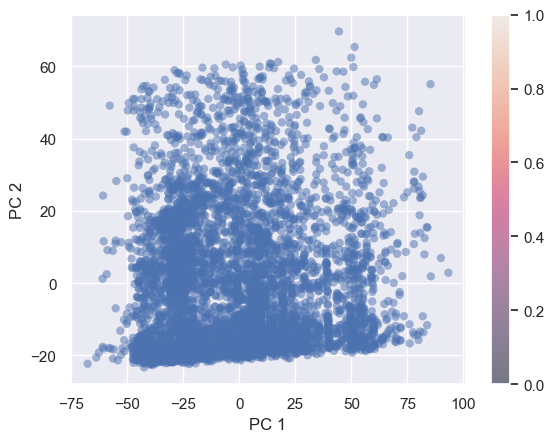

In [132]:
plt.scatter(reduced[:, 0], reduced[:, 1], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()

In [105]:
print(pca.explained_variance_ratio_)

[0.58043864 0.27888322]


Text(0, 0.5, 'explained variance')

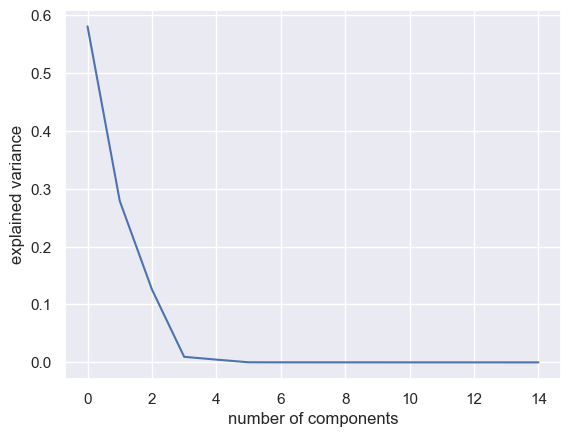

In [106]:
pca = PCA().fit(df)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')

In [107]:
# Convert back to DataFrame for readability
df_pca = pd.DataFrame(data=reduced)
df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]

df_pca.head()

,PC1,PC2
0,-5.458411,50.567424
1,-13.611868,42.981379
2,18.988176,44.520492
3,8.073062,32.540174
4,-40.239322,48.366063


### 4. Se divide en sets de training y test:

In [108]:
# Se entrena el modelo con una variable
x = df_pca['PC1'].values.reshape(-1, 1)
y = df_pca['PC2'].values.reshape(-1, 1)

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

### 5. Se estandarizan los datos:

In [110]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 6. Se aplica PCA:

In [111]:
# Make an instance of the Model
pca = PCA(.95)

In [112]:
pca.fit(X_train)

PCA(n_components=0.95)

### 7. Se aplica el  mapeo (transform) a los sets training y test:

In [113]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### 8. Se aplica regresión logística a la data transformada:

In [114]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [115]:
logisticRegr.fit(X_train, Y_train) #aquí surge un error que habrá que resolver

ValueError: Unknown label type: 'continuous'

In [116]:
#arreglando el error Unknown label type: 'continuous'

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
Y_transformed = lab.fit_transform(Y_train)

#view transformed values
print(y_transformed)

[3868 2532 2515 ... 2246  111  142]


In [117]:
logisticRegr.fit(X_train, Y_transformed)

LogisticRegression()

In [118]:
# Predict for One Observation (image)
logisticRegr.predict(X_test[0].reshape(1,-1))

array([631], dtype=int64)

In [119]:
# Predict for One Observation (image)
logisticRegr.predict(X_test[0:10])

array([ 631, 2725, 1731, 2725, 2725, 2725, 2725,  118,  118, 2725],
      dtype=int64)

In [120]:
regressor = LinearRegression()
regressor.fit(X_train, Y_transformed) #Creates model

LinearRegression()

Text(0.5, 0.98, 'Linear Regression Model')

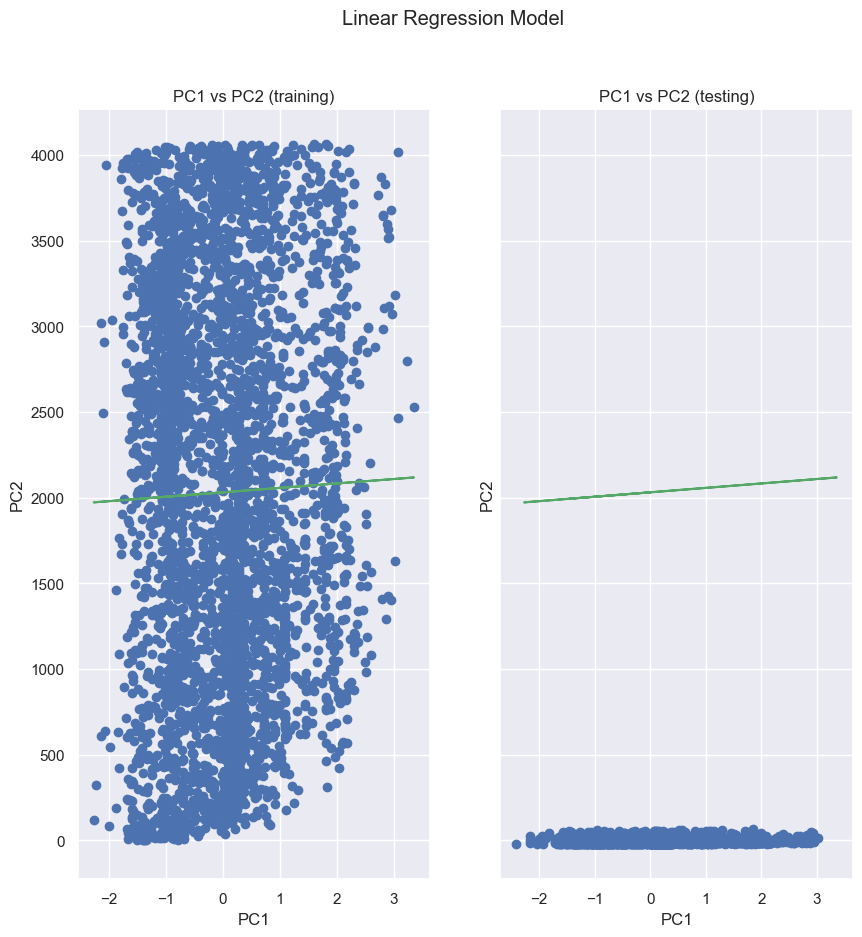

In [121]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
ax[0].scatter(X_train, Y_transformed)
ax[0].plot(X_train, regressor.predict(X_train), c='g')
ax[0].set_title('PC1 vs PC2 (training)')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].scatter(X_test, Y_test)
ax[1].plot(X_train, regressor.predict(X_train), c='g')
ax[1].set_title('PC1 vs PC2 (testing)')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
plt.suptitle('Linear Regression Model')

In [123]:
regressor.score(X_test, Y_test)

-11683.936498003926